### Importing Libraries

In [1]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import pickle

### Loading Data

In [2]:
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

### Functions

In [3]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('gbc__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))
        ])

        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)
    
def get_deafult_score(model_class, default_grid, scoring):
    default_scores = []
    for i in range(4):
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        default_scores.append(default_score)
    return default_scores

In [8]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': np.arange(50, 201, 50),
    'gbc__learning_rate': np.linspace(0.01, 0.2, 5),
    'gbc__max_depth': np.arange(3, 11),
    # from 0.01 to 0.2 with step 0.01
    'gbc__min_samples_leaf': [i/1000 for i in range(5,201,5)],
    'gbc__subsample': np.linspace(0.6, 1.0, 4),
    'gbc__max_features': [None, 'sqrt', 'log2'],
    'gbc__random_state': [seed]
}

In [9]:
%%time

gbc_opt_results_rs = tune_with_random_search(pipe_gbc, search_grid,100, 'roc_auc')

CPU times: user 4.55 s, sys: 1.36 s, total: 5.91 s
Wall time: 1min 16s


In [21]:
save_result(gbc_opt_results_rs,'./saved_results/gbc_opt_results_rs.pkl')

In [5]:
gbc_opt_results_rs=load_result('./saved_results/gbc_opt_results_rs.pkl')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GradientBoostingClassifier from version 1.4.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.2 when using version 1.4.0. This might lead to brea

In [10]:
for i in range(4):
    print(gbc_opt_results_rs[i].best_params_)

{'gbc__subsample': 1.0, 'gbc__random_state': 17, 'gbc__n_estimators': 100, 'gbc__min_samples_leaf': 0.14, 'gbc__max_features': None, 'gbc__max_depth': 8, 'gbc__learning_rate': 0.01}
{'gbc__subsample': 0.7333333333333333, 'gbc__random_state': 17, 'gbc__n_estimators': 50, 'gbc__min_samples_leaf': 0.02, 'gbc__max_features': None, 'gbc__max_depth': 3, 'gbc__learning_rate': 0.0575}
{'gbc__subsample': 1.0, 'gbc__random_state': 17, 'gbc__n_estimators': 100, 'gbc__min_samples_leaf': 0.015, 'gbc__max_features': None, 'gbc__max_depth': 8, 'gbc__learning_rate': 0.105}
{'gbc__subsample': 0.8666666666666667, 'gbc__random_state': 17, 'gbc__n_estimators': 50, 'gbc__min_samples_leaf': 0.01, 'gbc__max_features': 'log2', 'gbc__max_depth': 6, 'gbc__learning_rate': 0.15250000000000002}


In [11]:
gbc_tunabilities_rs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_rs, 'roc_auc')
gbc_tunabilities_rs

[0.01883538610512292,
 0.006790123456790198,
 0.012670441264316934,
 -0.0055569206474537225]

### Bayesian Optimization

In [12]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': np.arange(50, 201, 50),
    'gbc__learning_rate': np.linspace(0.01, 0.2, 5),
    'gbc__max_depth': np.arange(3, 11),
    # from 0.01 to 0.2 with step 0.01
    'gbc__min_samples_leaf': [i/1000 for i in range(5,201,5)],
    'gbc__subsample': np.linspace(0.6, 1.0, 4),
    'gbc__max_features': [None, 'sqrt', 'log2'],
    'gbc__random_state': [seed]
}

In [13]:
%%time

gbc_opt_results_bs = tune_with_bayes_search(pipe_gbc, search_grid,100, 'roc_auc')

CPU times: user 4h 40min 48s, sys: 2h 23min 30s, total: 7h 4min 18s
Wall time: 1h 30min 32s


In [20]:
save_result(gbc_opt_results_bs,'./saved_results/gbc_opt_results_bs.pkl')

In [9]:
gbc_opt_results_bs=load_result('./saved_results/gbc_opt_results_bs.pkl')

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GradientBoostingClassifier from version 1.4.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.2 when using version 1.4.0. This might lead to brea

In [14]:
for i in range(4):
    print(gbc_opt_results_bs[i].best_params_)

OrderedDict([('gbc__learning_rate', 0.01), ('gbc__max_depth', 6), ('gbc__max_features', None), ('gbc__min_samples_leaf', 0.14), ('gbc__n_estimators', 50), ('gbc__random_state', 17), ('gbc__subsample', 0.8666666666666667)])
OrderedDict([('gbc__learning_rate', 0.0575), ('gbc__max_depth', 4), ('gbc__max_features', None), ('gbc__min_samples_leaf', 0.005), ('gbc__n_estimators', 100), ('gbc__random_state', 17), ('gbc__subsample', 0.6)])
OrderedDict([('gbc__learning_rate', 0.15250000000000002), ('gbc__max_depth', 10), ('gbc__max_features', None), ('gbc__min_samples_leaf', 0.01), ('gbc__n_estimators', 100), ('gbc__random_state', 17), ('gbc__subsample', 1.0)])
OrderedDict([('gbc__learning_rate', 0.0575), ('gbc__max_depth', 3), ('gbc__max_features', 'sqrt'), ('gbc__min_samples_leaf', 0.005), ('gbc__n_estimators', 100), ('gbc__random_state', 17), ('gbc__subsample', 0.7333333333333333)])


In [15]:
gbc_tunabilities_bs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_bs, 'roc_auc')

gbc_tunabilities_bs

[0.026444941206454464,
 0.00758024691358028,
 0.014192981544841943,
 0.0013439347282536707]

### Plots

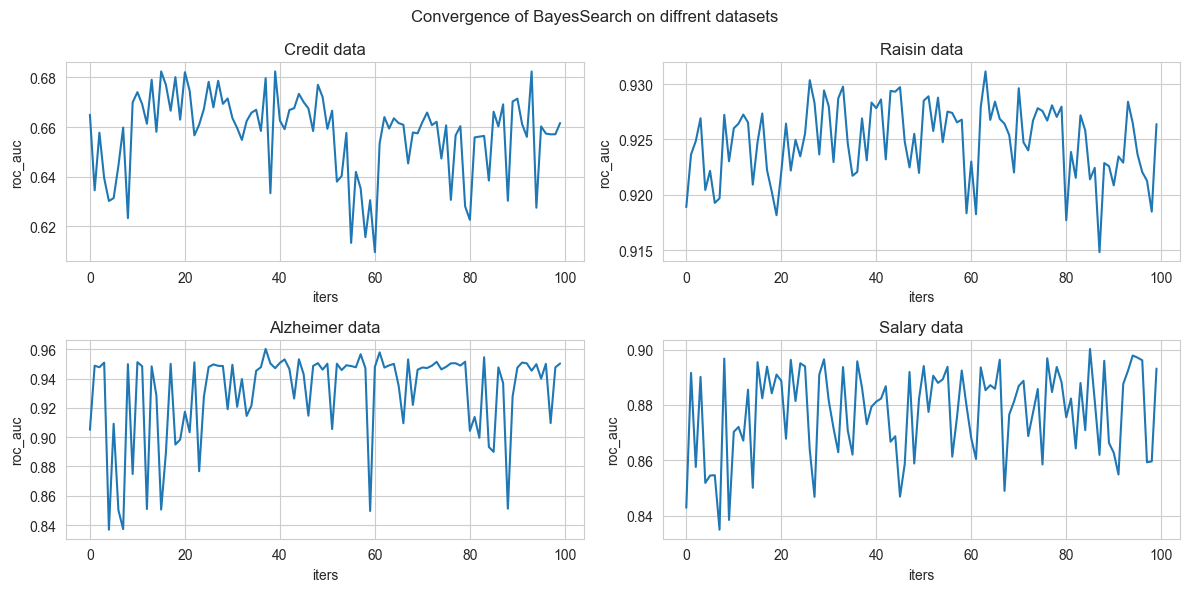

In [16]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(gbc_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

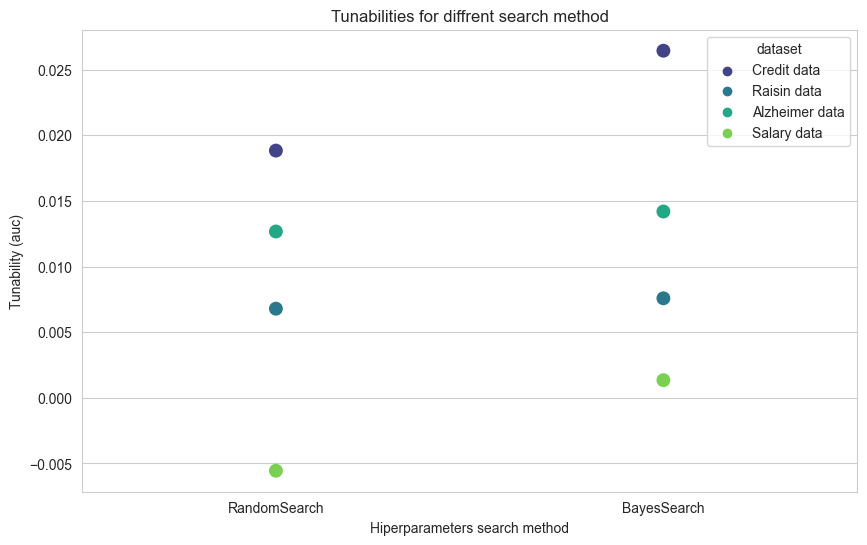

In [17]:
data = {
    'tunability': gbc_tunabilities_rs + gbc_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()

### Histogram of metric value differences

In [18]:
default_score = get_deafult_score(GradientBoostingClassifier, {'random_state': seed}, 'roc_auc')
default_score

[0.655991988640015, 0.9235679012345678, 0.9459800124939001, 0.8988651454138703]

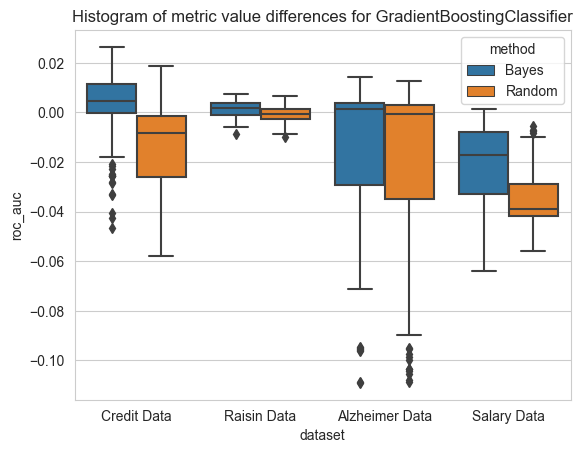

In [19]:
data = {
    'Credit Data': gbc_opt_results_bs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': gbc_opt_results_bs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': gbc_opt_results_bs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': gbc_opt_results_bs[3].cv_results_["mean_test_score"]-default_score[3]
}
data_random = {
    'Credit Data': gbc_opt_results_rs[0].cv_results_["mean_test_score"]-default_score[0],
    'Raisin Data': gbc_opt_results_rs[1].cv_results_["mean_test_score"]-default_score[1],
    'Alzheimer Data': gbc_opt_results_rs[2].cv_results_["mean_test_score"]-default_score[2],
    'Salary Data': gbc_opt_results_rs[3].cv_results_["mean_test_score"]-default_score[3]
} 
data = pd.DataFrame(data)
data_random = pd.DataFrame(data_random)
# connect datasets data and data_random, adding column with method Random and Bayes 
data['method'] = 'Bayes'
data_random['method'] = 'Random'
data = pd.concat([data, data_random])
data = data.melt(id_vars='method', var_name='dataset', value_name='roc_auc')

sns.boxplot(x='dataset', y='roc_auc', hue='method', data=data)
plt.title('Histogram of metric value differences for GradientBoostingClassifier')
plt.show()